In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Data

Data for communas:

- “comunas.csv” gives the communa name, comuna id, comuna longitude, comuna latitude, municipality name, municipality id

- “comunas_commutes.csv” gives the directed number of commutes (third column) between pairs of comuna ids (first two columns) in Medellín.

- "communas_gmaps.csv" contains the driving times, transit times and walking times (in seconds) between the different comunas. Edge (i,j) is how long it takes to drive from i to j (at 9am in the morning during the week)

- "comunas_firms.csv" gives the predicted number of commercial firms that are visible in Google Street Imagery (both formal and informal) in each comuna. 

- "comunas_pop.csv" gives the average population in 2020 within each communa. 

- "comunas_stratum.csv" contains the average stratum of the neighbourhoods in each comuna. Stratum is socio-economic indicator that is based on the quality of housing and infrastructure of a neighbourhood. The highest socio-economic scale is 6 (wealthy areas), and the lowest 1 (poor areas).  

Medellin metro: 

- “medellin_metro.xlsx” gives the name, line, communa name, comuna id, macrozone (linked to optional shape file), municipality name and id, latitude, longitude, stop type (metro, bus rapid transit, cable, or tramway), and transfer indicator for each metro stop. Subsequent rows on the same line share an edge. Some stops are repeated, as they are on multiple lines (transfer points).

Optional Data: 

- "communa_boundaries" gives the shape files of all the communas that can  be used if you would like to use any other open data available online.


In [2]:
metro_df = pd.read_csv('https://raw.githubusercontent.com/yiyansun/Medellin_metro/main/data/medellin_metro.csv')
communa_df = pd.read_csv('https://raw.githubusercontent.com/yiyansun/Medellin_metro/main/data/comunas.csv')
commutes_df = pd.read_csv('https://raw.githubusercontent.com/yiyansun/Medellin_metro/main/data/comunas_commutes.csv')
gmaps_df = pd.read_csv('https://raw.githubusercontent.com/yiyansun/Medellin_metro/main/data/comunas_gmaps.csv')
firms_df = pd.read_csv('https://raw.githubusercontent.com/yiyansun/Medellin_metro/main/data/comunas_firms.csv') 
pop_df = pd.read_csv('https://raw.githubusercontent.com/yiyansun/Medellin_metro/main/data/comunas_pop.csv')
stratum_df = pd.read_csv('https://raw.githubusercontent.com/yiyansun/Medellin_metro/main/data/comunas_stratum.csv')

In [3]:
communa_gdf = gpd.read_file('https://raw.githubusercontent.com/yiyansun/Medellin_metro/main/data/comunas_boundaries/MACROZONAS.shp')
communa_gdf.columns=['municipality','macrozona','geometry']
commmuna_gdf = communa_gdf.to_crs(epsg=6257)
communa_gdf

In [4]:
HEADERS = {
    'metro_df': ['stop', 'line', 'comuna_name', 'comuna_index', 'macrozona', 'municipality', 'muni_index', 'Lattitude', 'Longitude', 'type', 'transfer'],
    'communa_df': ['comuna name', 'comuna_index', 'municipality', 'muni_index', 'comuna longitude', 'comuna latitude', 'Macrozona_shapefile'],
    'commute_df': ['Origin', 'Destination', 'Relative number of trips'],
    'gmaps_df': ['travel_time_m', 'mode', 'origin', 'destination'],
    'firms_df': ['comuna_index', 'muni_index', 'num_firms'],
    'pop_df': ['comuna_index', 'muni_index', 'population'],
    'stratum_df': ['comuna_index', 'muni_index', 'stratum'],
    'communa_gdf': ['MUNICIPIO', 'MACROZONA', 'geometry'],
}


In [5]:
communa_df.rename(columns={'Macrozona _shapefile': 'macrozona'}, inplace=True)
communa_gdf.rename(columns={'MACROZONA': 'macrozona'}, inplace=True)
communa_gdf.rename(columns={'MUNICIPIO': 'municipality'}, inplace=True)

# Analysis

In [6]:
merged_df = pd.merge(communa_gdf[['macrozona','geometry']], communa_df, on = 'macrozona')
merged_df = pd.merge(merged_df,pop_df[['comuna_index','population']], on = 'comuna_index')
merged_df = pd.merge(merged_df,firms_df[['comuna_index','num_firms']], on = 'comuna_index')
final_df = pd.merge(merged_df,stratum_df[['comuna_index','stratum']], on = 'comuna_index')
final_df

,macrozona,geometry,comuna name,comuna_index,municipality,muni_index,comuna longitude,comuna latitude,population,num_firms,stratum
0,1.0,"POLYGON ((-75.61279 6.18084, -75.61243 6.18052...",Itagui-Comuna 06 ',1,'Itagui',8,-75.61493,6.176629,13458,494,1.901746
1,2.0,"POLYGON ((-75.61284 6.18427, -75.61274 6.18419...",Itagui-Comuna 05 ',2,'Itagui',8,-75.60698,6.180733,12853,949,2.040128
2,25.0,"POLYGON ((-75.64759 6.16577, -75.64759 6.16572...",Urbana La Estrella ',3,'La Estrella',9,-75.63781,6.142994,23758,1946,2.467947
3,6.0,"POLYGON ((-75.57469 6.36276, -75.57469 6.36271...",Bello-Comuna 06 ',4,'Bello',3,-75.56693,6.352998,19296,733,1.955026
4,5.0,"POLYGON ((-75.56883 6.35035, -75.56894 6.35034...",Bello-Comuna 05 ',5,'Bello',3,-75.56992,6.341258,22363,1459,2.206717
...,...,...,...,...,...,...,...,...,...,...,...
63,41.0,"POLYGON ((-75.44804 6.43546, -75.44801 6.43539...",Rural Girardota ',62,'Girardota',7,-75.44836,6.380775,10310,151,2.183294
64,27.0,"POLYGON ((-75.43592 6.39105, -75.43571 6.39031...",Urbana Girardota ',63,'Girardota',7,-75.44330,6.380888,5052,992,2.146245
65,47.0,"POLYGON ((-75.52505 6.28801, -75.52498 6.28802...",Corregimiento Santa Elena ',64,'Medellin',1,-75.51665,6.234823,218422,37,1.986825
66,31.0,"POLYGON ((-75.54807 6.30441, -75.54803 6.30440...",Popular ',65,'Medellin',1,-75.54420,6.293636,47820,685,1.510299


<Axes: >

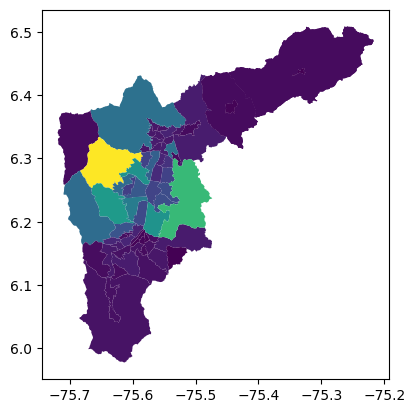

In [7]:
final_df.plot('population')

<Axes: >

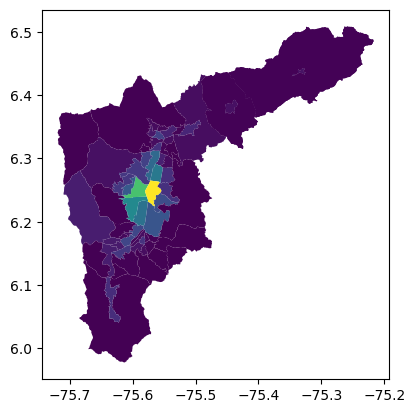

In [8]:
final_df.plot('num_firms')

<Axes: >

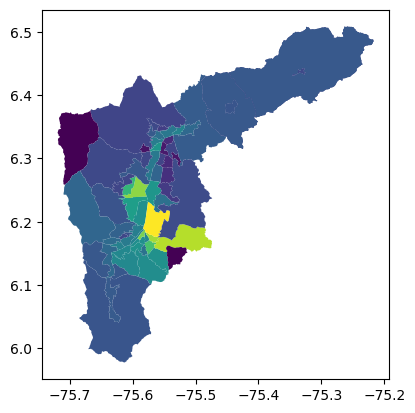

In [9]:
final_df.plot('stratum')

In [10]:
metro_gdf = gpd.GeoDataFrame(metro_df, geometry = [Point(xy) for xy in zip(metro_df['Longitude'], metro_df['Lattitude'])])
metro_gdf.set_crs(final_df.crs, inplace=True)


,stop,line,comuna_name,comuna_index,macrozona,municipality,muni_index,Lattitude,Longitude,type,transfer,geometry
0,Bello,A,Bello-Comuna 03,8,8,bello,3,6.337778,-75.544444,Metro,NaN,POINT (-75.54444 6.33778)
1,Palos verdes,L1,Manrique,9,13,medellin,1,6.330278,-75.553611,Bus rapid transit,L1,POINT (-75.55361 6.33028)
2,Gardel,L1,Manrique,9,13,medellin,1,6.315833,-75.555417,Bus rapid transit,L1,POINT (-75.55542 6.31583)
3,Manrique,L1,Manrique,9,13,medellin,1,6.300278,-75.558472,Bus rapid transit,L1,POINT (-75.55847 6.30028)
4,Las Esmeraldas,L1,Manrique,9,13,medellin,1,6.290597,-75.564258,Bus rapid transit,L1,POINT (-75.56426 6.29060)
...,...,...,...,...,...,...,...,...,...,...,...,...
89,Oriente,T-A,Villa Hermosa,61,20,medellin,1,6.268324,-75.554901,Tramway,H,POINT (-75.55490 6.26832)
90,Arvâ€™,L,Corregimiento Santa Elena,64,47,medellin,1,6.273219,-75.554192,Cable,NaN,POINT (-75.55419 6.27322)
91,Popular,K,Popular,65,31,medellin,1,6.278936,-75.552797,Cable,NaN,POINT (-75.55280 6.27894)
92,Santo Domingo Savio,K,Popular,65,31,medellin,1,6.283007,-75.552707,Cable,L,POINT (-75.55271 6.28301)


In [11]:
metro_stations = metro_gdf.loc[metro_gdf['type']=='Metro']
bus_stations = metro_gdf.loc[metro_gdf['type']=='Bus rapid transit']
cable_stations = metro_gdf.loc[metro_gdf['type']=='Tramway']
tram_stations = metro_gdf.loc[metro_gdf['type']=='Cable']

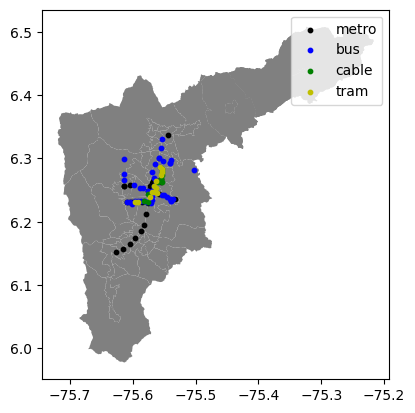

In [12]:
f, ax = plt.subplots()
final_df.plot(ax = ax, color = 'grey')
metro_stations.plot(ax = ax, color='k', markersize=10, label = 'metro')
bus_stations.plot(ax = ax, color='b', markersize=10, label = 'bus')
cable_stations.plot(ax = ax, color='g', markersize=10, label = 'cable')
tram_stations.plot(ax = ax, color='y', markersize=10, label = 'tram')
ax.legend()